## California Climate Risk and Adaptation Index Demo
This notebook walks through the Cal-CRAI calculation using synthetic historical data to demonstrate potential scores of resilience across California. 

**Intended Application**: I want to understand the Index results by: 
1. Calculating Cal-CRAI with equal weighted domains
2. Understanding potential weighting scenarios, where domains are weighted differently
3. Visualize the Cal-CRAI across California

#### Step 0: Set-up
First we will import several useful libraries to aid analysis. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# from utils import x

#### Step 1: Retrieve data
To calculate the Cal-CRAI index, we will need to read in several datasets including the  in census tract boundaries (to help with plotting). 

In [ ]:
# bucket_name = 'ca-climate-index'
# aws_dir = '3_fair_data/dummy_data/'

# # Search for non-zipped files
# pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False)

In [10]:
# read in index data (per domain)
df = gpd.read_file('output_folder/calcrai_adjustedcols_ready.csv')
df = df.drop(columns='field_1')
df['GEOID'] = '0' + df['GEOID']

df.head(5)

,GEOID,DUMMY_governance_summed_indicators_min_max_standardized,DUMMY_natural_summed_indicators_min_max_standardized,DUMMY_society_summed_indicators_min_max_standardized,DUMMY_built_summed_indicators_min_max_standardized,DUMMY_built_median,DUMMY_governance_median,DUMMY_natural_median,DUMMY_society_median,DUMMY_natural_tract_adjusted,DUMMY_society_tract_adjusted,DUMMY_built_tract_adjusted,geometry
0,06001400100,0.6789992014905509,0.744959677419355,0.5424883470778056,0.3998892273608418,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,0.5020325203252035,0.07763532763532767,-0.17907902217168867,None
1,06001400200,0.3140803832845356,0.1527217741935483,0.330225887414844,0.484907227914705,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,-0.6920731707317076,-0.34401709401709396,-0.004548038658328902,None
2,06001400300,0.548309821666223,0.0579637096774193,0.4991036213696664,0.5444475214621989,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,-0.883130081300813,-0.008547008547008638,0.11768050028425238,None
3,06001400400,0.5791855203619909,0.0614919354838709,0.4144854786661885,0.5516477430074771,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,-0.8760162601626018,-0.17663817663817666,0.1324616259238201,None
4,06001400500,0.536066010114453,0.7328629032258064,0.5891000358551451,0.5929105510938798,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,0.4776422764227641,0.1702279202279203,0.21716884593519029,None


In [13]:
climate_domain_min_max_data = pd.read_csv('DUMMY_climate_indicator_product.csv')
df['acute_risk'] = climate_domain_min_max_data[['min_max_standardized_from_product']] # add climate col to main df

In [14]:
# read in census tract boundaries
ca_census = gpd.read_file('tl_2021_06_tract.shp')
ca_census = ca_census.to_crs('EPSG:4326')

#### Step 2: Calculate Cal-CRAI

Equation for weighting... need to take a nicer image/code in more visually nice
<figure>
    <img src='index_eqn.png'>
</figure>
<!-- ![equation for calculating index](calcrai_eqn.png) -->

In [15]:
def weight_domains(df, society, built, natural):
    governance_col = 'DUMMY_governance_summed_indicators_min_max_standardized'
    society_adjusted_col = 'DUMMY_society_tract_adjusted'
    built_adjusted_col = 'DUMMY_built_tract_adjusted'
    natural_adjusted_col = 'DUMMY_natural_tract_adjusted' 

    weighting = (
        df[governance_col].astype(float) + 
        (society * (df[society_adjusted_col].astype(float) * df[governance_col].astype(float))) +
        (built * (df[built_adjusted_col].astype(float) * df[governance_col].astype(float))) +
        (natural * (df[natural_adjusted_col].astype(float) * df[governance_col].astype(float)))
    )

    df['calcrai_weighted'] = weighting
    return df

In [16]:
def calculate_index(df):
    df['calcrai_score'] = df['calcrai_weighted'] / df['acute_risk'].astype(float)

    # testing for 0 values --> divide error
    df.loc[df['acute_risk'] == 0, 'calcrai_score'] = 0
    
    return df

In [42]:
df_eq = weight_domains(df, society=1, built=1, natural=1)
df_eq = calculate_index(df_eq)

Let's print some results to see the range of values

In [43]:
print('Min score / less resilience: ', df_eq['calcrai_score'].min())
print('Max score / more resilience: ', df_eq['calcrai_score'].max())
print('Mean score / average resilience: ', df_eq['calcrai_score'].mean())
print('Median score / median resilience: ', df_eq['calcrai_score'].median())

Min score / less resilience:  -22.570847302680153
Max score / more resilience:  219.4195876658281
Mean score / average resilience:  1.8796311166762065
Median score / median resilience:  1.3368048373474357


In [44]:
# how many census tracts have resilience scores above 10*mean
print(len(df_eq.loc[df_eq['calcrai_score'] > (20*df_eq['calcrai_score'].mean())]))
df_eq.loc[df_eq['calcrai_score'] > (20*df_eq['calcrai_score'].mean())].head(5) # 23

# look into cause of census tracts with really large values (high governance coupled with low risk etc.)

10


,GEOID,DUMMY_governance_summed_indicators_min_max_standardized,DUMMY_natural_summed_indicators_min_max_standardized,DUMMY_society_summed_indicators_min_max_standardized,DUMMY_built_summed_indicators_min_max_standardized,DUMMY_built_median,DUMMY_governance_median,DUMMY_natural_median,DUMMY_society_median,DUMMY_natural_tract_adjusted,DUMMY_society_tract_adjusted,DUMMY_built_tract_adjusted,geometry,acute_risk,calcrai_weighted,calcrai_score
970,06019007202,0.5821133883417621,0.5972782258064516,0.7178200071710291,0.4862918859041817,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,0.20426829268292684,0.4259259259259264,-0.0017055144968732526,None,0.004320,0.947965,219.419588
1274,06029005205,0.3806228373702422,0.5438508064516129,0.8149874506991753,0.6283577956244808,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,0.09654471544715441,0.6189458689458692,0.2899374644684479,None,0.011449,0.763312,66.671922
1756,06037143101,0.685121107266436,0.7550403225806451,0.5471495159555396,0.4101356964829687,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,0.5223577235772356,0.08689458689458711,-0.15804434337691878,None,0.022651,0.994253,43.895146
1879,06037192520,0.5509715198296513,0.3497983870967742,0.7034779490856937,0.5840487399612295,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,-0.29471544715447157,0.3974358974358976,0.1989766913018758,None,0.010520,0.717198,68.175112
3424,06037576904,0.5286132552568539,0.4884072580645161,0.4069558981713875,0.4957075602326225,0.4871226806978677,0.5014639339898856,0.4959677419354839,0.503406238795267,-0.015243902439024404,-0.19159544159544165,0.017623649801023156,None,0.002557,0.428591,167.588584


#### Step 3: Visualize Results

In [45]:
def to_plot(df, scenario=None, save=False):
    # plotting help
    df2 = df.merge(ca_census, on='GEOID')
    df2['geometry'] = df2['geometry_y']
    df2 = df2.drop(columns = ['geometry_x','geometry_y'])
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4326)

    # set-up figure
    fig, ax = plt.subplots(1, 1, figsize=(4.5,6), layout='compressed')

    df2.plot(column='calcrai_score', ax=ax, vmin=-3, vmax=3, legend=True, cmap='RdYlBu',
            legend_kwds={'label':'Cal-CRAI scores', 'orientation': 'horizontal', 'shrink':0.7});

    if scenario == None:
        plt.annotate('Equal-weighted domains'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
    if scenario != None:
        plt.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    if save:
        fig.savefig('dummy_ca_map.png', dpi=300, bbox_inches='tight')

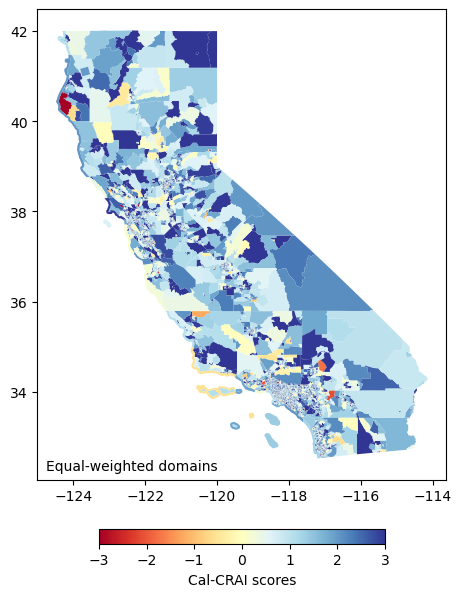

In [46]:
to_plot(df_eq)

In [48]:
# different weighting
df_fire = weight_domains(df, society=10, built=4, natural=0.5)
df_fire = calculate_index(df_fire)

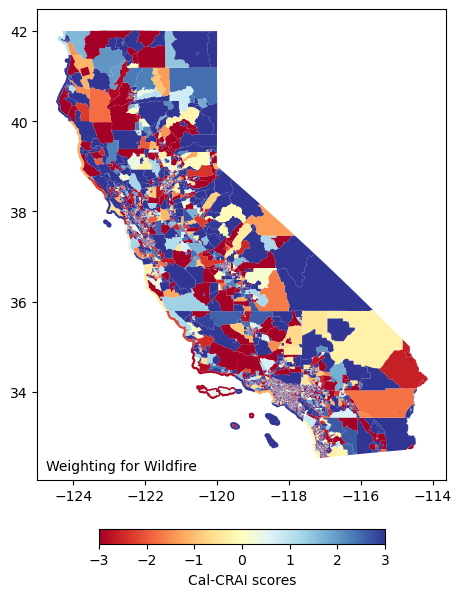

In [49]:
to_plot(df_fire, scenario='Wildfire', save=True)

Zoom in on some area of interest

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,6), layout='compressed')

df3.plot(column='crsi_results', ax=ax, vmin=-3, vmax=3, legend=True, cmap='RdYlBu',
        legend_kwds={'label':'Cal-CRAI Index value', 'orientation': 'horizontal', 'shrink':0.7});
ca_census.boundary.plot(ax=ax, color='black', linewidth=0.1) # only use for zoomed in plots -- otherwise it obscures the boundary
ax.set_ylim(37.5, 38.5);
ax.set_xlim(-122.7, -121.);
# fig.savefig('dummy_ca_map.png', dpi=300, bbox_inches='tight')

Figures of each domain

In [ ]:
# next!